# Fraud Detection System

### Data Mining Pipeline
1. Data Collection
2. Data Analysis and Visualization
3. Data Pre-processing
4. Model Selection and Training
5. Model Evaulation 

In [1]:
!pip install kaggle

In [2]:
# data retrieval
import os
import io
import zipfile
import shutil

# data analysis
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# other
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Data Collection (Retrieval Using Kaggle Key)
- You must have a Kaggle account and API key to retrieve their dataset. To retrieve the key, follow: https://www.kaggle.com/docs/api
- Then, download the paysim1.zip from https://www.kaggle.com/datasets/ealaxi/paysim1 and add within the same directory as this notebook file.

In [3]:
# Set your Kaggle API key credentials (replace with your own values)
os.environ['KAGGLE_USERNAME'] = 'your_username'
os.environ['KAGGLE_KEY'] = 'your_api_key'

In [4]:
if not os.path.exists("paysim1.zip"):
    # Use Kaggle CLI to download the "paysim1" dataset
    !kaggle datasets download -d ealaxi/paysim1
    
if os.path.exists("paysim1.zip"):
    with zipfile.ZipFile("paysim1.zip", "r") as zip_ref:
        zip_ref.extractall("paysim1")
        
    # Specify the path to the CSV file
    csv_file_path = "paysim1/PS_20174392719_1491204439457_log.csv"
    
    # Read the CSV file content into memory
    with open(csv_file_path, "rb") as f:
        csv_content = f.read()
    shutil.rmtree("paysim1")
else:
    print("The paysim1.zip file is missing. Dataset not downloaded.")


### Data Analysis
In the next two sections, we will perform a data analysis by description and by data visualization.

After reading in the dataset, we see eleven different features:
- **step**: time transaction occurred (1 step = 1 hour)
- **type**: type of transaction (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)
- **amount**: amount of money (dollars) involved
- **nameOrig**: ID of sender
- **oldbalanceOrg**: initial balance of sender
- **newbalanceOrig**: final balance of sender
- **nameDest**: ID of recipient
- **oldBalanceDest**: initial balance of recipient
- **newBalanceDest**: final balance of recipient
- **isFraud**: a flag for fraudulent (1) and non-fraudulent (0) transactions
- **isFlaggedFraud**: a flag that checks if transaction has been flagged as fraud (1) or not (0)

In [5]:
data = pd.read_csv(io.BytesIO(csv_content))
print(data.columns.values)

['step' 'type' 'amount' 'nameOrig' 'oldbalanceOrg' 'newbalanceOrig'
 'nameDest' 'oldbalanceDest' 'newbalanceDest' 'isFraud' 'isFlaggedFraud']


From the names of the attributes shown, we find inconsistency in the naming convention. We update the name of newBalanceOrg to newbalanceOrig to match with the other attribute names.

In [6]:
data.rename(columns={'newbalanceOrig':'newbalanceOrg'},inplace=True)

In the first step of our analysis, we check to see if our data set has any null values. 
We find that there are **no NULL values** in all eleven features.

In [7]:
print('Data does not have any NULL value.')
data.isnull().any()

Data does not have any NULL value.


step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrg     False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

**Feature Data Types**

Next, we check the data types for the eleven features. Here, we found:
* Three features are object/string type.
* Three features are integers.
* Five features are floats.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrg   float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Out of the three object types, we drop **nameOrig** and **nameDest**, because they are **nominal** data types that can increase unnecessary complexity. This leaves us with only nine features to wrangle with.

In [9]:
data.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


Finally, we note the minimum and maximum values of the amount, oldbalanceOrig, newbalanceOrig, oldbalanceDest, and newBalanceDest. *Something interesting to note is that there are transaction amounts that is at $0, after applying the minimum. This indicates that no money was sent or received in certain transactions.*

In [10]:
print('Minimum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].min()

Minimum value of Amount, Old/New Balance of Origin/Destination:


amount            0.0
oldbalanceOrg     0.0
newbalanceOrg     0.0
oldbalanceDest    0.0
newbalanceDest    0.0
dtype: float64

We find that any time the amount is $0, the transaction is always fraudulent. Interestingly, this is not reflected in the isFlaggedFraud column.

In [11]:
print(data[data['amount'] == 0][['amount', 'isFraud', 'isFlaggedFraud']])

         amount  isFraud  isFlaggedFraud
2736447     0.0        1               0
3247298     0.0        1               0
3760289     0.0        1               0
5563714     0.0        1               0
5996408     0.0        1               0
5996410     0.0        1               0
6168500     0.0        1               0
6205440     0.0        1               0
6266414     0.0        1               0
6281483     0.0        1               0
6281485     0.0        1               0
6296015     0.0        1               0
6351226     0.0        1               0
6362461     0.0        1               0
6362463     0.0        1               0
6362585     0.0        1               0


In [12]:
print('Maximum value of Amount, Old/New Balance of Origin/Destination:')
data[[ 'amount','oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']].max()

Maximum value of Amount, Old/New Balance of Origin/Destination:


amount            9.244552e+07
oldbalanceOrg     5.958504e+07
newbalanceOrg     4.958504e+07
oldbalanceDest    3.560159e+08
newbalanceDest    3.561793e+08
dtype: float64

### Data Visualization

First, we group the data by type. Then we sum the total transaction amount by type. Hence, we see the total transaction amount per type in the bar graph below.

Text(0, 0.5, 'Amount')

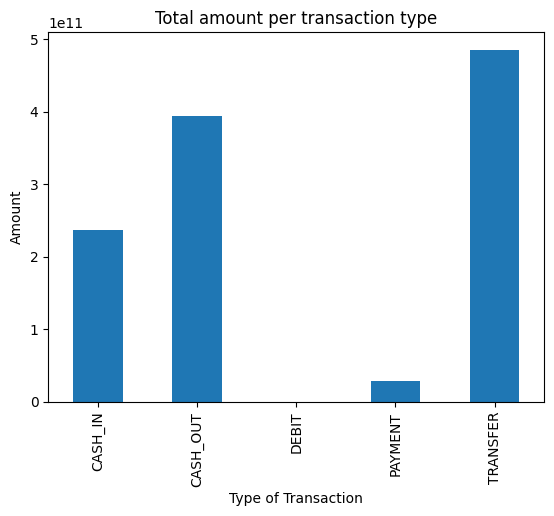

In [13]:
var = data.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount')

We can check which transaction type contain fraudulent transactions. First, we find all data which is fraudulent. Then we retrieve the types of fraudulent data. Here, we find that only the **TRANSFER** and **CASH_OUT** transactions contain fraudulent data.

In [14]:
data.loc[data.isFraud == 1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [15]:
sns.heatmap(data.corr(),cmap='RdBu');

ValueError: could not convert string to float: 'PAYMENT'

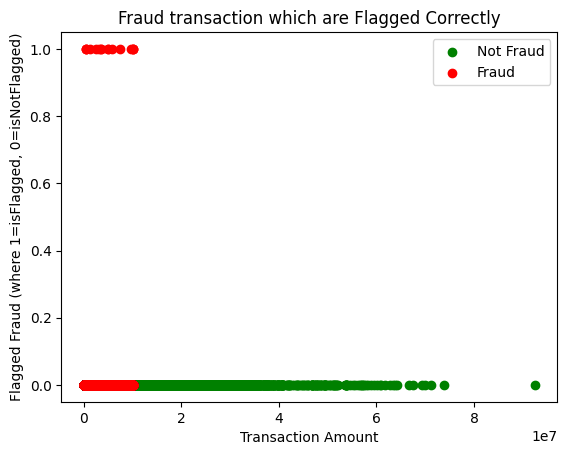

In [16]:
fraud = data.loc[data.isFraud == 1]
nonfraud = data.loc[data.isFraud == 0]

fig = plt.figure()
axes = fig.add_subplot(1,1,1)
axes.set_title("Fraud transaction which are Flagged Correctly")
axes.scatter(nonfraud['amount'],nonfraud['isFlaggedFraud'],c='g')
axes.scatter(fraud['amount'],fraud['isFlaggedFraud'],c='r')

plt.legend(loc='upper right',labels=['Not Fraud','Fraud'])
plt.xlabel('Transaction Amount')
plt.ylabel('Flagged Fraud (where 1=isFlagged, 0=isNotFlagged)')
plt.show()

The plot above clearly shows the need for a system which can be fast and reliable to mark the transaction which is fraud. Since, the current system is letting fraud transaction able to pass through a system which is not labeling them as a fraud.

#### Classification Report of Original Model (before preprocessing)

In [17]:
print("Classification Report for Original Model:")
print(classification_report(data['isFraud'], data['isFlaggedFraud'], digits=8))
print("Actual Fraudulent Transactions that were Flagged Fraud:", len(fraud.loc[fraud.isFlaggedFraud==1]))
print("Actual Fraudulent Transactions that were NOT Flagged Fraud:", len(fraud.loc[fraud.isFlaggedFraud==0]))

Classification Report for Original Model:
              precision    recall  f1-score   support

           0  0.99871169 1.00000000 0.99935543   6354407
           1  1.00000000 0.00194813 0.00388869      8213

    accuracy                      0.99871169   6362620
   macro avg  0.99935585 0.50097407 0.50162206   6362620
weighted avg  0.99871335 0.99871169 0.99807046   6362620

Actual Fraudulent Transactions that were Flagged Fraud: 16
Actual Fraudulent Transactions that were NOT Flagged Fraud: 8197


As of checkpoint 2, we also included a classification report of the original model the data was trained on. We can see that the original model has incredible precision, but has terrible recall (almost 0%). This means although, it will always be correct in classifying fraudulent transactions (hence, a good precision), it will basically never flag anything as fraudulent which renders it useless.

### Data Pre-processing

First, we perform vectorization by converting the transaction type from a string object to integer type. This way, it can be used as input for machine learning algorithms.

In [18]:
data = data.replace(to_replace={'PAYMENT':1,'TRANSFER':2,'CASH_OUT':3,'CASH_IN':4,'DEBIT':5})

Next, we drop the **isFlaggedFraud** since this is generated by a previous model which we will replace.

In [19]:
data.drop(['isFlaggedFraud'],axis=1,inplace=True)
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest,isFraud
0,1,1,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,1,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,2,181.00,181.0,0.00,0.0,0.0,1
3,1,3,181.00,181.0,0.00,21182.0,0.0,1
4,1,1,11668.14,41554.0,29885.86,0.0,0.0,0


### Machine Learning Model
#### Explore Different DM Methods

In [20]:
train, test = train_test_split(data, test_size=0.6)

# create training dataset
y_train = train['isFraud']
X_train = train.drop(['isFraud'], axis=1)

# create test dataset
X_test = test.drop(['isFraud'], axis=1)
y_test = test['isFraud']

#### Decision Tree Classifier

In [21]:
# build decision tree and train
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
# predict using the trained decision tree
y_pred = decision_tree_classifier.predict(X_test)

In [23]:
# evaluate accuracy of decision tree
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report for Original Decision Tree Model:")
print(classification_report(y_test, y_pred))

print(decision_tree_classifier.tree_.max_depth)

Accuracy: 0.9996463720919998
Classification Report for Original Decision Tree Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3812704
           1       0.87      0.85      0.86      4868

    accuracy                           1.00   3817572
   macro avg       0.94      0.92      0.93   3817572
weighted avg       1.00      1.00      1.00   3817572

34


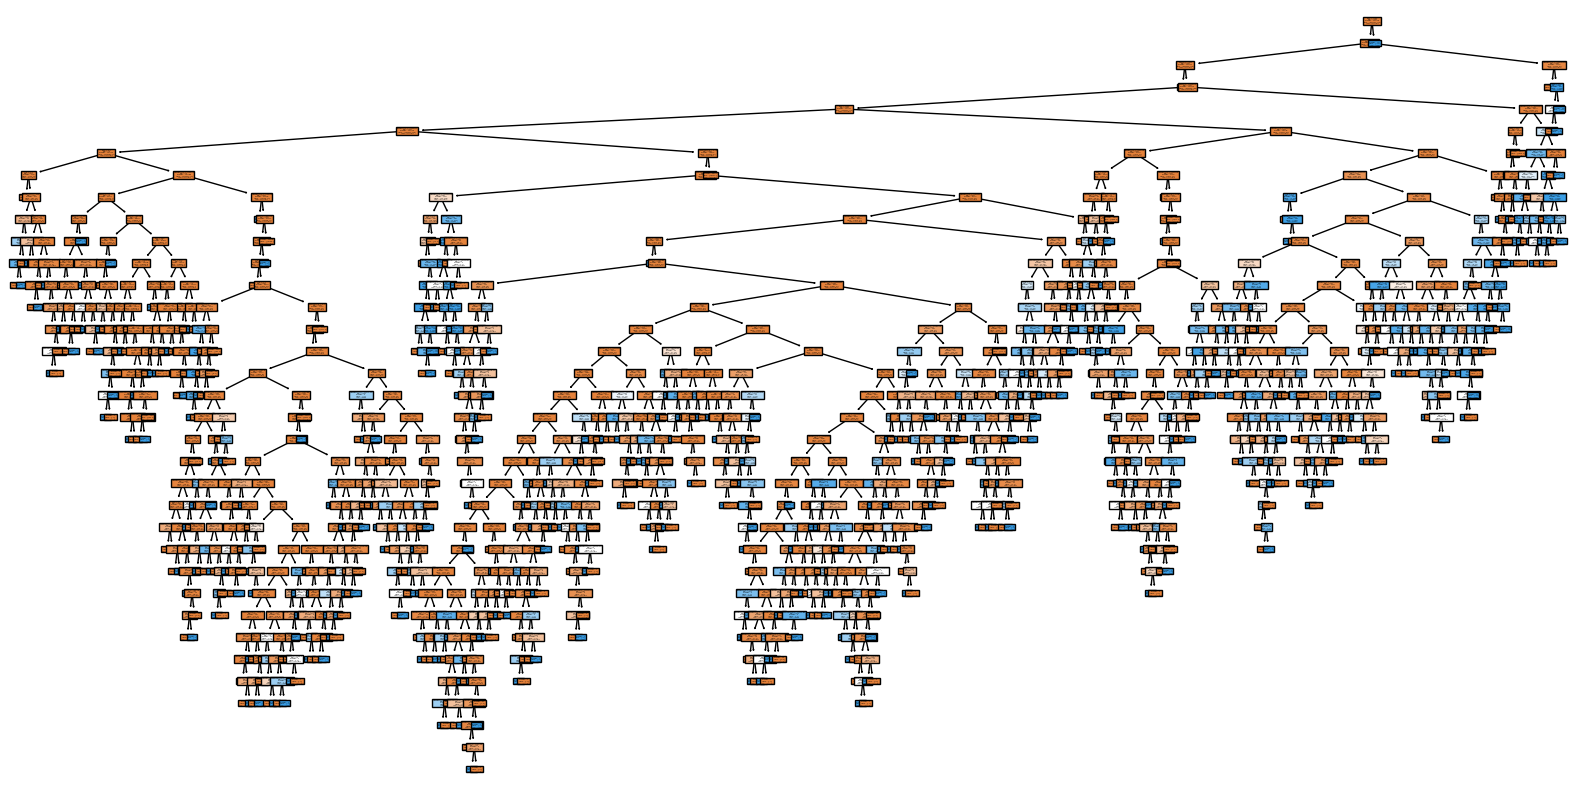

In [24]:
# plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, filled=True, feature_names=X_train.columns, class_names=["Not Fraud", "Fraud"])
plt.show()

#### Issue #1: Decision Tree Model is Overfit

Our current accuracy is **99.97%**. However, the decision tree model above is very deep and complex, which is indicative of **overfitting**. For improving we can set a maximum height to our tree.

##### Improvement: Set a Maximum Depth of Tree

First, let's try to systematically find the optimal depth of the tree before setting the maximum height. In this case, we will be using a 5-fold cross validation technique, to calculate the best precision, recall, and f1 score values at varying depths.

In [25]:
depth_range = list(range(1, 20))  
param_grid = {'max_depth': depth_range}
decision_tree_classifier = DecisionTreeClassifier()

# calculate best precision and depth
grid_precision = GridSearchCV(decision_tree_classifier, param_grid, cv=5, scoring='precision', return_train_score=False)
grid_precision.fit(X_train, y_train)
print("Best precision: ", grid_precision.best_score_)
print("Best max_depth for precision: ", grid_precision.best_params_['max_depth'])

# calculate best recall and depth
grid_recall = GridSearchCV(decision_tree_classifier, param_grid, cv=5, scoring='recall', return_train_score=False)
grid_recall.fit(X_train, y_train)
print("Best recall: ", grid_recall.best_score_)
print("Best max_depth for recall: ", grid_recall.best_params_['max_depth'])

# calculate best F1 score and depth
grid_f1 = GridSearchCV(decision_tree_classifier, param_grid, cv=5, scoring='f1', return_train_score=False)
grid_f1.fit(X_train, y_train)
print("Best F1 score: ", grid_f1.best_score_)
print("Best max_depth for F1 score: ", grid_f1.best_params_['max_depth'])


Best precision:  1.0
Best max_depth for precision:  1
Best recall:  0.8008968609865471
Best max_depth for recall:  19
Best F1 score:  0.8466685445975968
Best max_depth for F1 score:  19


Now, let's re-train the data with a maximum depth from the report above.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3812704
           1       0.92      0.81      0.86      4868

    accuracy                           1.00   3817572
   macro avg       0.96      0.90      0.93   3817572
weighted avg       1.00      1.00      1.00   3817572



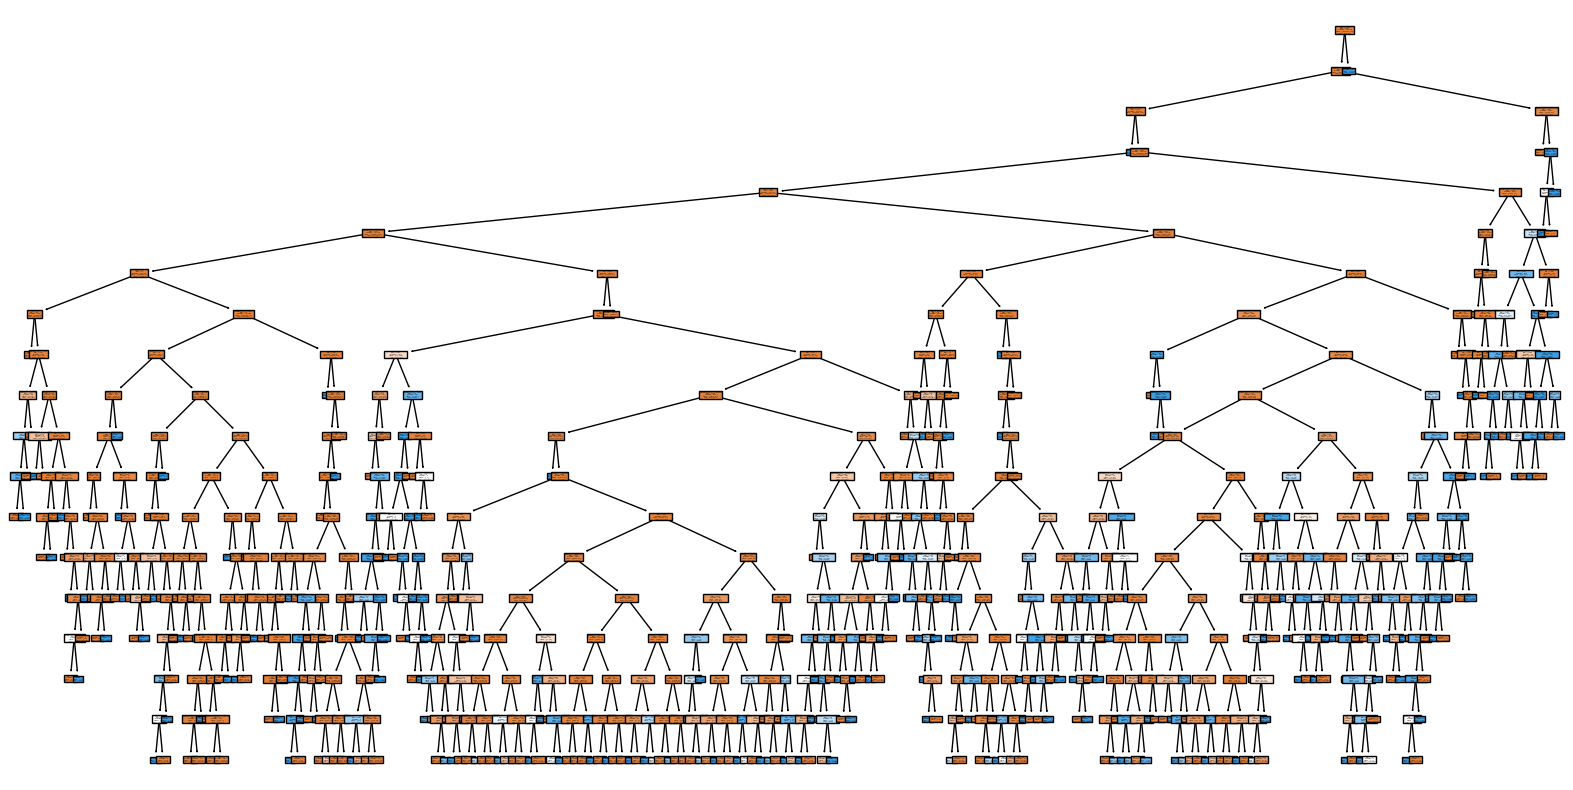

In [26]:
# retrain data with decision tree model with a max depth of 18
decision_tree_classifier = DecisionTreeClassifier(max_depth=18)
decision_tree_classifier.fit(X_train, y_train)
y_pred = decision_tree_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, filled=True, feature_names=X_train.columns, class_names=["Not Fraud", "Fraud"])
plt.show()

#### Random Forest Classifier

In [27]:
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train, y_train)
y_pred_rf = random_forest_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Model Accuracy:", accuracy_rf)
print("Classification Report for Random Forest Model:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model Accuracy: 0.9996992853049006
Classification Report for Random Forest Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3812704
           1       0.99      0.77      0.87      4868

    accuracy                           1.00   3817572
   macro avg       0.99      0.89      0.93   3817572
weighted avg       1.00      1.00      1.00   3817572



#### Logistic Regression Model

In [28]:
logistic_regression_classifier = LogisticRegression(random_state=42)
logistic_regression_classifier.fit(X_train, y_train)
y_pred_lr = logistic_regression_classifier.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Model Accuracy:", accuracy_lr)
print("Classification Report for Logistic Regression Model:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Model Accuracy: 0.9983015382552052
Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3812704
           1       0.36      0.45      0.40      4868

    accuracy                           1.00   3817572
   macro avg       0.68      0.72      0.70   3817572
weighted avg       1.00      1.00      1.00   3817572



#### Issue #2: Logistic Regression Classifier have very low precision and recall values

For the logistics regression model:

According to our precision value, we see that out of all transactions that the model labelled fraudulent, only 0.37 or **37%** were actually fraudulent (true positives).

According to our recall value, we see that out of all the transactions that were actually fraudulent, we only caught 0.42 or **42%** of those fraudulent, and the rest were labelled legitimate. Meaning, we missed 58% of all total fraudulent transactions we could have caught.

This is not good performance, and therefore we should look towards improving our logistic regression model.

Note the following precision and recall functions:

precision = true positive / (true positive + false positive).
recall = true positive / (false negative + true positive).

##### Improvement: A Logistic Regression model with L1 regularization

In [29]:
logistic_regression_l1 = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=42)
logistic_regression_l1.fit(X_train, y_train)
y_pred_l1 = logistic_regression_l1.predict(X_test)
accuracy_l1 = accuracy_score(y_test, y_pred_l1)
print("Logistic Regression (L1 Regularization) Model Accuracy:", accuracy_l1)
print("Classification Report for L1 Regularization Model:")
print(classification_report(y_test, y_pred_l1))

Logistic Regression (L1 Regularization) Model Accuracy: 0.9992951017033863
Classification Report for L1 Regularization Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3812704
           1       0.91      0.50      0.64      4868

    accuracy                           1.00   3817572
   macro avg       0.95      0.75      0.82   3817572
weighted avg       1.00      1.00      1.00   3817572



#### Compare accuracy between models

In [30]:
print("Original Decision Tree Model Accuracy:", accuracy)
print("Random Forest Model Accuracy:", accuracy_rf)
print("Logistic Regression Model Accuracy:", accuracy_lr)
print("Logistic Regression (L1 Regularization) Model Accuracy:", accuracy_l1)

Original Decision Tree Model Accuracy: 0.9996463720919998
Random Forest Model Accuracy: 0.9996992853049006
Logistic Regression Model Accuracy: 0.9983015382552052
Logistic Regression (L1 Regularization) Model Accuracy: 0.9992951017033863
